# 3.1: Pre-processing and Transformation

**Runtime: ~10s**

*In this part the datasets are imported, encoded, empty values are replaced with appropriate data, and the most relevant features are selected.* \
*Lines **longer than 80** characters are continued on a new line.*

## Importing required libraries & datasets
*Modules required for this task are impored below.*

In [1]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder,\
    MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, r_regression, chi2, f_regression
import matplotlib.pyplot as plt

A function to load the datasets is created and is used to load both datasets.

In [2]:
def load_dataset(name: str) -> np.ndarray:
    """
    Function that will load CSV dataset without the first row i.e., header.
    
    Args:
        name (str): The name of the dataset including extension e.g., data.csv
        
    Returns:
        np.ndarray: Numpy array containing the dataset
    """
    
    return np.genfromtxt(name, delimiter=',', skip_header=True, dtype='str')

In [3]:
# Load datasets
if __name__ == "__main__":
    starsSet = load_dataset('star_assessment.csv')
    gwpSet = load_dataset('gwp_assessment.csv')

## Encoding
*This section handles the encoding of the datasets.* \
*The **OneHotEncoder** has been found efficient and therefore is the encoder used for both datasets.*

In [4]:
def encode_dataset(dataset: np.ndarray, encoding_type: str) -> list:
    """
    Function that will find non-numerical values in a dataset and convert
    them to numerical values using either ordinal, one-hot or label encoder.
    The type of all samples in the dataset will be converted to float.
    Missing and incorrectly encoded values will be replaced by Nan.
    
    Args:
        dataset (np.ndarray): The dataset that will be encoded
        encoding_type (str): The type of encoding to be performed
        
    Returns:
        list: [
            dataset: The encoded dataset
            non_numerical_cols: List of integers
        ]
    """
    
    non_numerical_cols = []
    
    # Convert string values to numerical values...
    for i, val in enumerate(dataset[0,:]):
        # ...Only if the current column is non-numerical
        if not val.replace(".","").isnumeric():  
            non_numerical_cols.append(i)
            
            if encoding_type == 'ordinal-encoder':
                oec = OrdinalEncoder(categories='auto', dtype=float)
                oec.fit(dataset[:, [i]])
                dataset[:,i] = oec.transform(dataset[:,[i]]).flatten()
                
            elif encoding_type == 'one-hot-encoder':
                ohc = OneHotEncoder(categories='auto', dtype=float,\
                                    sparse_output=False)
                ohc.fit(dataset[:, [i]])
                encoded_array = ohc.transform(dataset[:,[i]])
                dataset[:,i] = np.argmax(encoded_array, axis=1)
                
            elif encoding_type == 'label-encoder':
                le = LabelEncoder()
                le.fit(dataset[:, [i]].flatten())
                encoded_array = le.transform(dataset[:,[i]].flatten())
                dataset[:, [i]] = encoded_array.reshape((-1, 1))
                
    # Replace missing values with Nan
    dataset = np.where(dataset=='', np.nan, dataset)
    dataset = dataset.astype(float)
    
    # Replace non-numerical values that are encoded incorrectly with Nan
    if i != len(dataset[0]) - 1:
        for col in non_numerical_cols:
            dataset[:,col] = np.where(dataset[:,col]==0.0,\
                np.nan, dataset[:,col])
    
    return [dataset, non_numerical_cols]

In [5]:
# Encode both datasets
if __name__ == "__main__":
    encoding_data_stars = encode_dataset(starsSet, 'one-hot-encoder')
    encoded_dataset_stars = encoding_data_stars[0]
    encoding_data_gwp = encode_dataset(gwpSet, 'one-hot-encoder')
    encoded_dataset_gwp = encoding_data_gwp[0]

## Imputation

*In this section the datasets are imputed i.e., missing values are replaced.* \
*A combination of two different imputers is used for this purpose - **SimpleImputer** is used only for categorical data i.e., non-numerical data, and **IterativeImputer** for the remaining empty fields.*

In [6]:
def simple_imputer(dataset: np.ndarray, non_numerical_cols: list, \
                   only_categories: bool=False) -> np.ndarray:
    """
    Simple imputer function that will replace Nan data with computed value.
    For categorical data e.g., days of the week, it will be replaced with
    the median value, and for numerical data it will be replaced with
    mean.
    
    Args:
        dataset (np.ndarray): The dataset to be imputed
        non_numerical_cols (list): List of non-numerical columns
        only_categories (bool): If only categorical columns should be imputed
        
    Returns:
        np.ndarray: The imputed dataset
    """
    
    for index, val in enumerate(dataset[0,:]):
        if index in non_numerical_cols:
            imputer = SimpleImputer(missing_values=np.nan, strategy='median')
            dataset[:,[index]] = imputer.fit_transform(dataset[:,[index]])
            
        elif index not in non_numerical_cols and not only_categories:
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            dataset[:,[index]] = imputer.fit_transform(dataset[:,[index]])
            
    return dataset

In [7]:
def KNN_imputer(dataset: np.ndarray, n_neighbors: int=5) -> np.ndarray:
    """
    KNN imputer that will replace Nan data with computed value.
    It calculates each missing value from the mean of nearest 
    neighbors who's number could be configured in n_neighbors variable.
    
    Args:
        dataset (np.ndarray): The dataset to be imputed
        n_neighbors (int): The number of nearest neighbors to be
            used in the algorithm
    
    Returns:
        np.ndarray: The imputed dataset
    """
    
    imputer = KNNImputer(n_neighbors=n_neighbors)
    dataset = imputer.fit_transform(dataset)
    
    return dataset

In [8]:
def iterative_imputer(dataset: np.ndarray, max_iter: int=10,\
                      n_nearest_features: int=None) -> np.ndarray:
    """
    Iterative imputer that will replace Nan data with computed value.
    It calculates each missing value from all the others and could be
    customised by adding different imputation rounds and the number of
    nearest features looked.
    
    Args:
        dataset (np.ndarray): The dataset to be imputed
        max_iter (int): The number of maximum iterations
        n_nearest_features (None | int): The number of
            nearest features to be used
            
    Returns:
        np.ndarray: The imputed dataset
    """
    
    imputer = IterativeImputer(max_iter=max_iter,\
                               n_nearest_features=n_nearest_features)
    dataset = imputer.fit_transform(dataset)
    
    return dataset

In [9]:
# Imputate both datasets
if __name__ == "__main__":
    imputed_dataset_stars = iterative_imputer(simple_imputer(encoded_dataset_stars,\
                                    encoding_data_stars[1], only_categories=True))
    imputed_dataset_gwp = iterative_imputer(simple_imputer(encoded_dataset_gwp,\
                                    encoding_data_gwp[1], only_categories=True))

## Rescalling data

*In this section the datasets are rescaled.* \
*The scaler used for both datasets is the **MinMax** scaler.*

In [10]:
def scale_data(dataset: np.ndarray, scalling_type: str) -> np.ndarray:
    """
    Scaler function that will put all features in given range so it
    is easier to train a model with it. It has two types of scalling;
    min-max that will scale data in range 0,1 and robust that will
    scale the data according to the quantile ranges.
    
    Args:
        dataset (np.ndarray): The dataset to be scaled
        scalling_type (str): The scalling type to be used
    
    Returns:
        np.ndarray: The scaled dataset
    """
    
    if scalling_type == 'min-max':
        scaler = MinMaxScaler()
        
    elif scalling_type == 'robust':
        scaler = RobustScaler()
        
    scaled_dataset = scaler.fit_transform(dataset[:,:-1])
    scaled_dataset = np.concatenate([scaled_dataset, dataset[:,-1][:, np.newaxis]], axis=1)
    
    return scaled_dataset

In [11]:
# Rescale both datasets
if __name__ == "__main__":
    scalled_dataset_stars = scale_data(imputed_dataset_stars, 'min-max')
    scalled_dataset_gwp = scale_data(imputed_dataset_gwp, 'min-max')

## Selecting appropriate number of features
*In this section the best features from each dataset are selected and the rest - discarded.* 

To select an appropriate number of features from each dataset I will use the following methods:

**Categorical dataset**
1. Use **chi2** statistic to return p value between each feature and class
2. Values lower than 0.05 are considered statistically significant and selected as appropriate features

**Regression dataset**
1. Use r_regression to return the Pearson’s correlation between each features and target
2. Absolute values higher than 0.1 are considered statistically significant and selected as appropriate

**Filtering dataset** \
Once the most significant features are selected, **SelectKBest** is used to return only the part of the dataset that has the suitable features

**Note:** ***Pearson's correlation** (r_regression) assumes a linear relationship between the variables and is better suited for continuous variables. Such linear relationship can be found in the **GWP dataset** and therefore using that model for feature selection is a good choice.* \
*On the other hand, categorical variables found in the **Stars dataset** may not have that linear relationship between them; and therefore **Chi2** (Chi-squared) is a good choice for that dataset, as it is better fitted to the nature of the data and can lead to better model performance.*

In [12]:
def calc_pearson_correlation(dataset: np.ndarray) -> np.ndarray:
    """
    Returns the Pearson's correlation of each feature.
    
    Args:
        dataset (np.ndarray): The dataset to be computed
    
    Returns:
        np.ndarray: The Pearson's correlation of each feature
    """
    
    return r_regression(dataset[:, :-1], dataset[:, -1])

In [13]:
def calc_p_value(dataset: np.ndarray) -> np.ndarray:
    """
    Returns the P-value of each feature.
    
    Args:
        dataset (np.ndarray): The dataset to be computed
    
    Returns:
        np.ndarray: The P-value of each feature
    """
    
    return chi2(dataset[:, :-1], dataset[:, -1])

### Best features of the Stars dataset

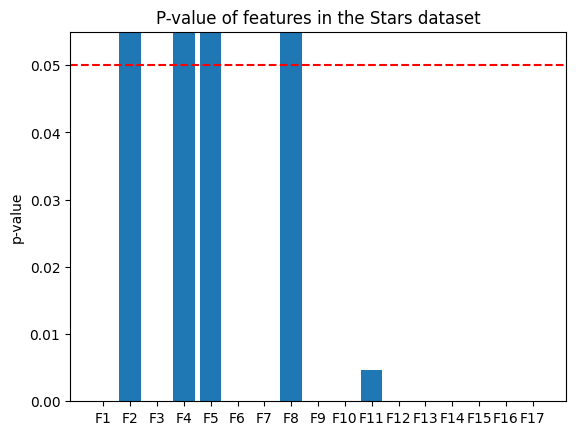

In [14]:
# Display graph that shows P-values for each feature of the Stars dataset
if __name__ == "__main__":
    cf = calc_p_value(scalled_dataset_stars)[1]
    feature_labels = ["F{}".format(i+1) for i in range(cf.size)]

    fig, ax = plt.subplots()
    ax.bar(np.arange(0,cf.size), cf)
    ax.set_xticks(np.arange(0, cf.size))
    ax.set_xticklabels(feature_labels)
    ax.set_ylabel('p-value')
    ax.set_title('P-value of features in the Stars dataset')
    ax.axhline(y=0.05, color='r', linestyle='dashed')
    ax.set_ylim(0, 0.055)
    plt.show()

*Suitable features from **Stars dataset** are calculated based on if their **P-value** is lower than 0.05 and therefore good features are: **F1**, **F3**, **F6**, **F7**, **F9**, **F11**, **F12**, **F13**, **F14**, **F15**, **F16** and **F17** or namely **12** our of **17** features.* \
**F10** is not selected as it is ***Nan*** value.

### Best features of the GWP dataset

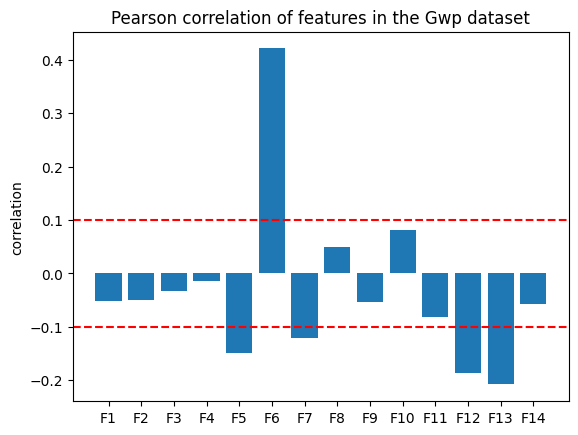

In [15]:
# Display graph that shows Pearson correlation for each feature of the Gwp dataset
if __name__ == "__main__":
    cf_b = calc_pearson_correlation(scalled_dataset_gwp)
    feature_labels_b = ["F{}".format(i+1) for i in range(cf_b.size)]

    fig_b, ax_b = plt.subplots()
    ax_b.bar(np.arange(0,cf_b.size), cf_b)
    ax_b.set_xticks(np.arange(0, cf_b.size))
    ax_b.set_xticklabels(feature_labels_b)
    ax_b.set_ylabel('correlation')
    ax_b.set_title('Pearson correlation of features in the Gwp dataset')
    ax_b.axhline(y=-0.1, color='r', linestyle='dashed')
    ax_b.axhline(y=0.1, color='r', linestyle='dashed')
    plt.show()

*Suitable features from **GWP dataset** are **F5**, **F6**, **F7**, **F12**, and **F13** or namely **5** our of **14** features.*

### Select the K-best features
After the number of well-performing features has been found for both datasets, now I use **SelectKBest** to reduce the size of each dataset to only its K-best features.

In [16]:
def select_best_features(dataset: np.ndarray, k: int, \
                         categorical_data: bool=False) -> np.ndarray:
    """
    Select the K-best features from a dataset by using either f_regression
    (for categorical data) or chi2 (for regression) to determine their
    suitability. Returns a subset of the dataset with k columns.
    
    Args:
        dataset (np.ndarray): The dataset to be computed
        k (int): The number of best features to be selected
        categorical_data (bool): If dataset is categorical or not
        
    Returns:
        np.ndarray: The reduced dataset containing the best features only
    """
    
    if categorical_data:
        skb = SelectKBest(chi2, k=k)
        
    else:
        skb = SelectKBest(f_regression, k=k)
        
    best_features = skb.fit_transform(dataset[:, :-1], dataset[:, -1])
    
    return np.concatenate([best_features, dataset[:, -1][:, np.newaxis]], axis=1)

In [17]:
# Select best features for both datasets
if __name__ == "__main__":
    best_features_stars = select_best_features(scalled_dataset_stars, 12, categorical_data=True)
    best_features_gwp = select_best_features(scalled_dataset_gwp, 5)

**With this the Pre-processing and Transformation of both datasets are imported, encoded, imputed, and refined to the most relevant features.**